## Coupling a quantum emitter to the boundary of a Harper-Hofstadter lattice

In this notebook, we present the code used to simulate the interaction between a quantum emitter and a Harper-Hofstadter lattice. The Hamiltonian we are aiming to simulate reads 

$$ H = H_\text{bath} + H_\text{QE} + H_\text{int}$$

where $H_\text{bath}$ represent the Harper-Hofstadter Hamiltonian describing the photonic bath, $H_\text{QE}$ stands for the emitter Hamiltonian and the emitter-bath interaction is encoded in $H_\text{int}$. The quantum emitter is a two-level system with a ground $|g\rangle$ and an excited $|e\rangle$ state. Assuming that the emitter is coupled to the bath at a position $\textbf{r}_e$ and denoting $\sigma_{\alpha\beta}=|\alpha\rangle\langle\beta|$, the different terms can be written as

\begin{align}
H_\text{bath}&=-J\sum_{x,y} a_{x+1,y}^\dagger a_{x,y} +  a_{x,y+1}^\dagger a_{x,y}e^{-2\pi\phi i x}+\text{H.c.}\\
H_\text{QE}&=\omega_e\sigma_{ee}\\
H_\text{int}&=ga_{\textbf{r}_e}\sigma_{eg}+\text{H.c.}
\end{align}

where we already set the local photonic mode energy to be the reference energy of the system, dropping the term $\omega_a\sum_{\textbf{r}}a_{\textbf{r}}^\dagger a_{\textbf{r}}$ in the bath Hamiltonian.

In [3]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from __future__ import print_function
from scipy.linalg import expm
from use_functions import *

#Plotting
styles = ['science']
prefix = 'stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.linewidth'] = 1 #set the value globally

import warnings
warnings.filterwarnings("ignore")

In the $\texttt{use-functions-py}$ module, we included a function $\texttt{get-relative-decay-rate}$ that computes the decay rate of the quantum emitter onto a specific topological channel $l$, and returns the relative decay $\Gamma_l/\Gamma$, and the total decay rate $\Gamma=\sum_l \Gamma_l$.

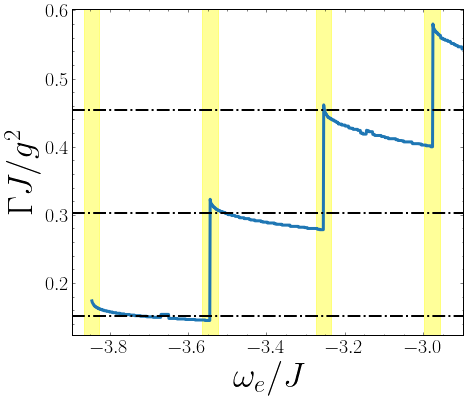

In [12]:
rd, td, energies = get_relative_decay_rate(0.05, q, num_edge, N=1000, threshold=threshold, n=200)

fig, ax = plt.subplots(figsize=(7,6))
ax.plot(energies[1:], np.array(td[1:])/g**2, linewidth=3)
ax.set_xlabel('$\omega_e/J$', fontsize=35)
ax.set_ylabel('$\Gamma J/g^2$', fontsize=35)
ax.set_xlim([min(energies)-0.05, -2.9])
#ax.set_ylim([100, 1700])

for l in range(num_edge):
    e_min = Landau_energy(l,q)-0.02
    e_max = Landau_energy(l,q)+0.02
    ax.axvspan(e_min, e_max, alpha=0.4, color='yellow')

# Compute mean Gamma across the lowest band-gap
min_index = np.argmin((energies-Landau_energy(0,q))**2)
max_index = np.argmin((energies-Landau_energy(1,q))**2)
lowest_BG_mean = np.mean(np.array(td[min_index:max_index])/g**2)

[ax.axhline((l+1)*lowest_BG_mean, linestyle='dashdot', color='black',
            linewidth=2) for l in range(3)]
plt.savefig('images/decay_rate_jumps.svg')

One of the key features of this system we analyse in our work is the spontaneous generation of time-bin single-particle entanglement of modes propagating through the boundary of  the Harper-Hofstadter lattice.

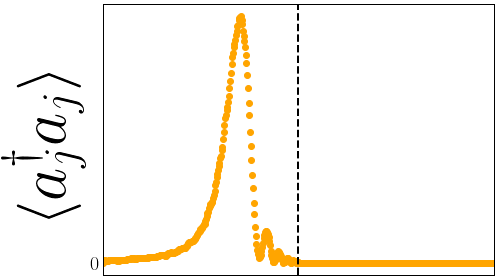

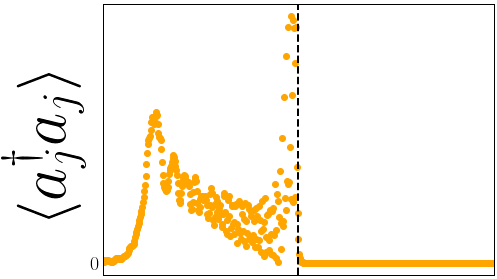

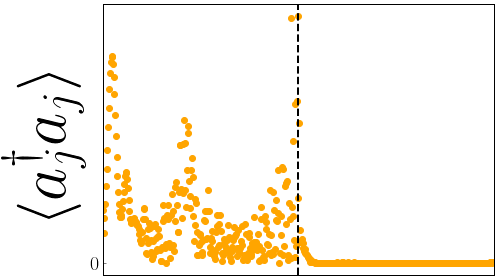

In [2]:
# Set parameters
q = 9                                                        # Inverse magnetic flux
efreqs = [Landau_energy(l, 9)+0.05 for l in range(3)]        # Quantum emitter frequencies
L = 500                                                      # System size
g = 0.1                                                      # Coupling constant
Ts = [800, 150, 150]                                         # Time instants to evaluate snapshot

for l in range(3):
    
    # Declare parameters and set lattice sites
    efreq, T = efreqs[l], Ts[l]
    sites = np.arange(L)
    
    # Declare light-matter Hamiltonian
    H = total_hamiltonian(efreq, L, q, g=g, PBC=False)

    # Compute dynamics and plot
    fig, ax = plt.subplots(figsize=(7,5))
    left_pops, _ = dynamics_left_edge(H,T)
    
    #Plot
    ax.plot(sites, left_pops, 'o', markersize=6, color = 'orange')
    ax.set_ylabel('$\langle a_j^\dagger a_j\\rangle$', fontsize=65)
    ax.axvline(x=L//2, linestyle='dashed', linewidth=2, color='black')
    ax.set_xlim([0, L])
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=3)
    plt.xticks([])
    plt.yticks([0])

Another fundamental advantage of the system is the robustness against disorder provided by the topological origin of these edge modes. Indeed, we can plot a snapshot of real-space dynamics of a single-photon propagation along the boundary in the presence of a defect, and observe that for both single- and multi-mode scenarios, the excitation is capable of surpassing the defect without backscattering effects.

In [17]:
def plot_dynamics_OBC(C, T=200, save=False, defects=[], L=50):
    
    efreq = Landau_energy(C-1,9)+0.1
    g = 0.05
    q = 9
    
    H = total_hamiltonian(efreq, L, q, g=g, PBC=False, defects=defects)
    all_pops, _ = dynamics_left_edge(H, T, full_lattice=True)
    all_pops = np.flip(all_pops, axis=0)
    
    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(all_pops, interpolation=None, norm=colors.LogNorm(vmin=0.0003, vmax=all_pops.max()))
    ax.set_xlabel('$X$', fontsize=25)
    ax.set_ylabel('$Y$', fontsize=25)
    ax.set_ylim([49,0])

    if len(defects)>0:
        x, y = np.arange(L), np.arange(L)
        defects = np.array(defects)
        x_defect, y_defect = x[defects//L], y[defects%L]
        X_defect, Y_defect = np.meshgrid(x_defect,y_defect)
        ax.scatter(X_defect, L - Y_defect, c='white', marker='s', s=90)
    
    if save is True: plt.savefig('gif_frames/'+str(C)+'_'+str(T)+'.png')
        
    return im

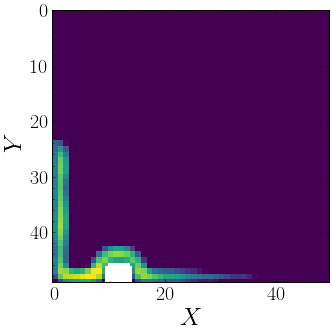

In [18]:
defects = [m + 50*(n+10) for n in range(4) for m in range(4)]
plot_dynamics_OBC(1, defects=defects)

Apart from snapshots at a fixed time of spontaneous emission, a different visual representation of pulse separation can be made through space-time diagrams where propagation light-cones become clearly distinguishable due to the difference in group velocities between the different topological channels.

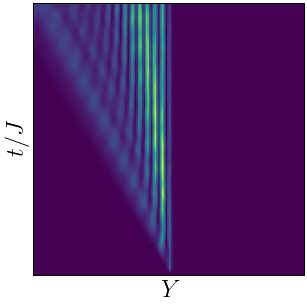

In [26]:
def plot_light_cones(n=100):
    
    # Set parameters
    q = 9
    efreq = Landau_energy(1, 9)+0.3
    L = 150
    g = 0.1
    T = 50
   
    fig, ax = plt.subplots(figsize=(7,5))
    
    # Define Hamiltonian and compute populations
    H = total_hamiltonian(efreq, L, q, g=g, PBC=False)
    populations = dynamics_left_edge_reps(H, T, n=n)
        
    # Plot with equilibrated proportion
    im = ax.imshow(populations)
    extent =  im.get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    plt.xticks([])
    plt.yticks([])
    
    # Legend: Bandgap Chern number in each case
    ax.set_ylabel('$t/J$', fontsize=25)
    ax.set_xlabel('$Y$', fontsize=25)
    plt.show()

plot_light_cones()

In the paper, we also developed a method for selectively couple the emitter to the topological channels by engineering non-local couplings. In particular, if the emitter is resonant to an edge mode $l$ such that $\omega_l(k_e^{(l)})=\omega_e$, the emission onto this channel can be cancelled by setting a non-local coupling of the form $g_{(0,y)}=g$ and $g_{(0,y+1)}=ge^{i(\pi-k_e^{(l)})}$. This will lead to a vanishing coupling $G(k_e^{(l)})=0$, where the $k_y$-dependent coupling is defined as

$$ G(k_y)=\frac{1}{\sqrt{L_y}}\sum_y g_y e^{-i k_y y}$$

In [5]:
# Set parameters
efreq = -1.86
L, g, T = 600, 0.2, 150
ks = np.linspace(-np.pi, np.pi, L)
q = 9
sites = np.arange(L)

# Compute dynamics and apply Fourier transform
H = total_hamiltonian(efreq, L, q, g=g, PBC=False)
left_edge_coherences, C_e = dynamics_left_edge_coherences(H, T, project=False)

# Get designed couplings and compute dynamics
gs, _ = get_minimal_target_coupling(g, q, efreq, H.shape[0]-1, mode_to_cancel=0)
H = total_hamiltonian_giant_atom(efreq, L, q, gs, PBC=False)
left_edge_coherences_giant_atom_0, _ = dynamics_left_edge_coherences(H, T, project=False)

gs, _ = get_minimal_target_coupling(g, q, efreq, H.shape[0]-1, mode_to_cancel=1)
H = total_hamiltonian_giant_atom(efreq, L, q, gs, PBC=False)
left_edge_coherences_giant_atom_1, _ = dynamics_left_edge_coherences(H, T, project=False)

Text(0, 0.5, '$|A(0,Y;T)|^2$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


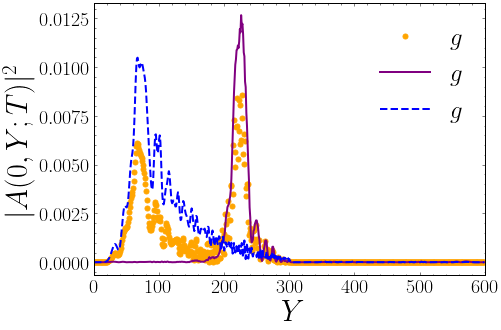

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(sites, np.abs(left_edge_coherences)**2, 'o', markersize=5, color='orange', label='$g$')
ax.plot(sites, np.abs(left_edge_coherences_giant_atom_0)**2, linewidth=2, color='purple', label='$g$')
ax.plot(sites, np.abs(left_edge_coherences_giant_atom_1)**2, linewidth=2, color='blue', label='$g$', linestyle='dashed')
ax.set_xlabel('$Y$', fontsize=30)
ax.set_xlim([0,L])
ax.legend(fontsize=25)
ax.set_ylabel('$|A(0,Y;T)|^2$', fontsize=30)